In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask
import cftime
import random
import glob
import matplotlib.gridspec as gs
import xgcm

In [2]:
from dask.distributed import Client, LocalCluster
client = Client()
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44711 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44711/status,
Dashboard: /proxy/44711/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36999,Workers: 7
Dashboard: /proxy/44711/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:40925,Total threads: 2
Dashboard: /proxy/46033/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:38943,


In [3]:
#open random year from control experiment

In [4]:
DS = xr.open_dataset("/g/data/hh5/tmp/zg0866/cm000_APP4_archive/cm000/history/ocn/ocean_month.nc-09601231", use_cftime=True, chunks= {"time":12})

In [5]:
temp_tendency = DS.temp_tendency

In [6]:
sw_heat = DS.sw_heat

In [7]:
temp_advection = DS.temp_sweby_advec

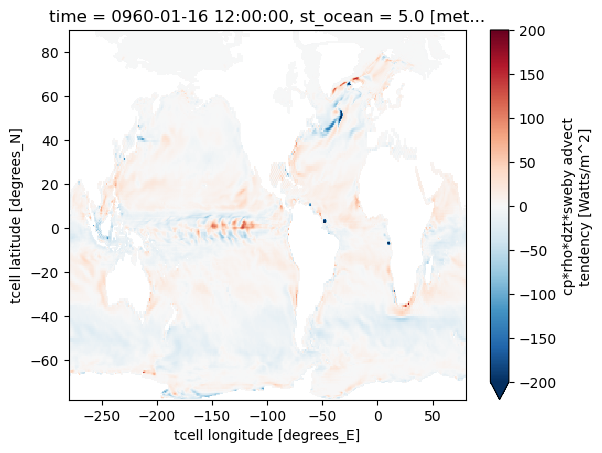

In [12]:
temp_advection[0,0].plot(vmin = -200)

In [13]:
rivermix = DS.temp_rivermix
temp_vdiffuse_sbc = DS.temp_vdiffuse_sbc
sfc_hflux_pme = DS.sfc_hflux_pme

In [14]:
frazil_3d = DS.frazil_3d

In [15]:
temp_vdiffuse_diff_cbt = DS.temp_vdiffuse_diff_cbt

In [16]:
temp_nonlocal_KPP = DS.temp_nonlocal_KPP

In [17]:
temp_submeso = DS.temp_submeso

In [18]:
temp_vdiffuse_k33 = DS.temp_vdiffuse_k33

In [19]:
neutral_diffusion_temp = DS.neutral_diffusion_temp

In [20]:
neutral_gm_temp = DS.neutral_gm_temp

In [21]:
mixdownslope_temp = DS.mixdownslope_temp
temp_sigma_diff = DS.temp_sigma_diff
temp_eta_smooth = DS.temp_eta_smooth

In [22]:
#now look at only the top layer

In [23]:
Qnet_0 = (sw_heat[:,0] + rivermix[:,0] + temp_vdiffuse_sbc[:,0] +sfc_hflux_pme)

In [24]:
Vmix_0 = temp_vdiffuse_diff_cbt[:,0]+temp_nonlocal_KPP[:,0]

In [25]:
misc_mix_0 = temp_eta_smooth +mixdownslope_temp[:,0] + temp_sigma_diff[:,0]

In [26]:
Sum = temp_advection[:,0]+temp_submeso[:,0]+Vmix_0+Qnet_0+frazil_3d[:,0]+temp_vdiffuse_k33[:,0]+neutral_diffusion_temp[:,0]+neutral_gm_temp[:,0]+misc_mix_0

In [27]:
Sum = Sum.compute()

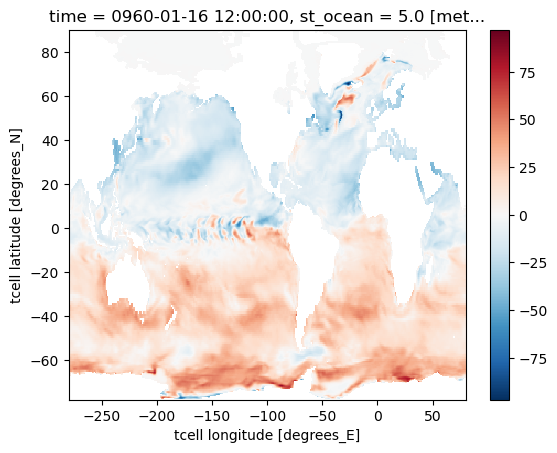

In [28]:
Sum[0].plot()

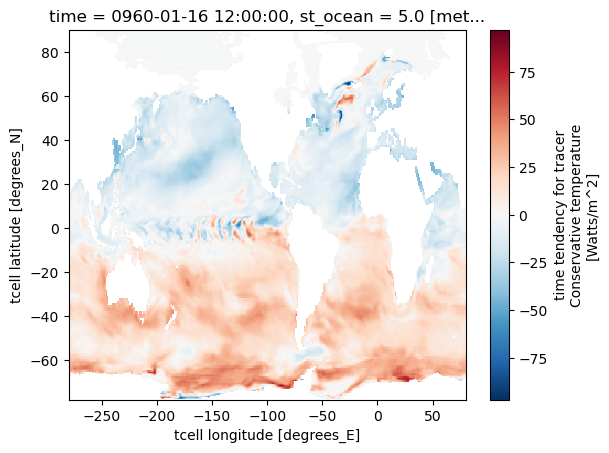

In [29]:
temp_tendency[0,0].plot()

In [30]:
#both these look similar, check the difference

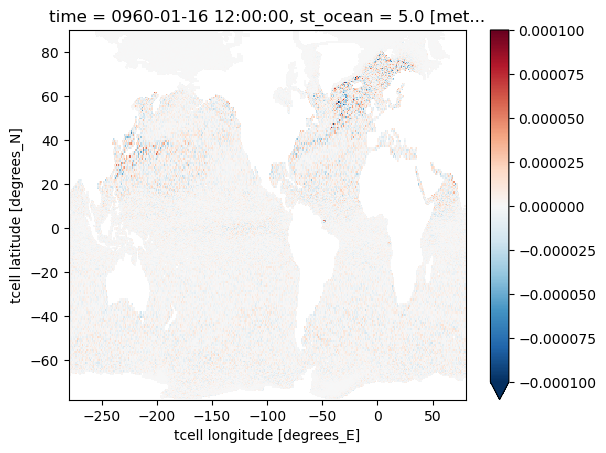

In [31]:
(temp_tendency[0,0] - Sum[0]).plot(vmin = -1e-4)

In [32]:
#This is pretty good for closure, there are probably some very small mixing terms lost somewhere maybe?

In [33]:
#lets integrate each term to 50 meteres to get a sense of the heat in the 50m layer

In [34]:
Qnet_50 = (sw_heat + rivermix + temp_vdiffuse_sbc).sel(st_ocean = slice(0,50)).sum("st_ocean")  + sfc_hflux_pme
#sfc_hflux_pme is only surface layer so cannot integate this term. The dz factor is already included in these fluxes so only need to sum

In [35]:
Vmix_50 = (temp_vdiffuse_diff_cbt+temp_nonlocal_KPP).sel(st_ocean = slice(0,50)).sum("st_ocean")

In [36]:
misc_mix_50 = temp_eta_smooth +(mixdownslope_temp+ temp_sigma_diff).sel(st_ocean = slice(0,50)).sum("st_ocean")
#temp_eta_smooth is a surface only flux so not integrated.

In [37]:
temp_advection_50 = temp_advection.sel(st_ocean = slice(0,50)).sum("st_ocean")
temp_submeso_50 = temp_submeso.sel(st_ocean = slice(0,50)).sum("st_ocean")
frazil_3d_50 = frazil_3d.sel(st_ocean = slice(0,50)).sum("st_ocean")
temp_vdiffuse_k33_50 = temp_vdiffuse_k33.sel(st_ocean = slice(0,50)).sum("st_ocean")
neutral_diffusion_temp_50 = neutral_diffusion_temp.sel(st_ocean = slice(0,50)).sum("st_ocean")
neutral_gm_temp_50 = neutral_gm_temp.sel(st_ocean = slice(0,50)).sum("st_ocean")

In [38]:
Sum50 = temp_advection_50+temp_submeso_50+Vmix_50+Qnet_50+frazil_3d_50+temp_vdiffuse_k33_50+neutral_diffusion_temp_50+neutral_gm_temp_50+misc_mix_50

In [39]:
Sum50 = Sum50.compute()

In [40]:
dTdt_50 = temp_tendency.sel(st_ocean = slice(0,50)).sum("st_ocean")

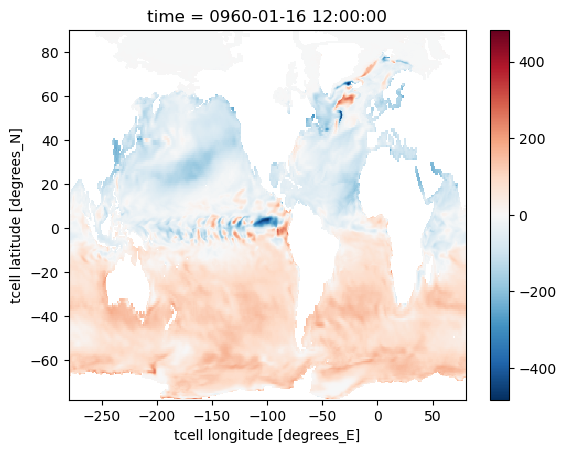

In [41]:
Sum50[0].plot()

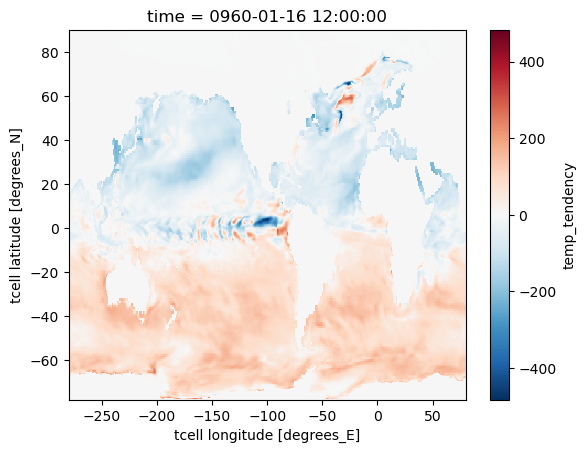

In [42]:
dTdt_50[0].plot()

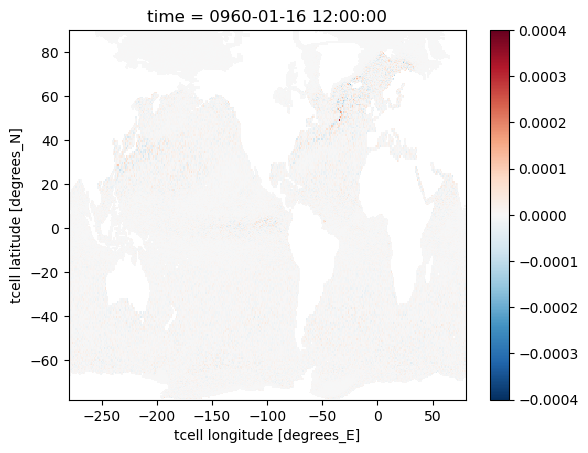

In [43]:
(dTdt_50-Sum50)[0].plot(vmin = -4e-4)

In [44]:
#now lets have a look at an offline calcualtion of heat advection (onyl at surface and see how far off we are.

In [45]:
temp = DS.temp

In [46]:
u = DS.u

In [47]:
v = DS.v

In [48]:
w = DS.wt

In [49]:
dyt = DS.dyt

In [50]:
dxt = DS.dxt

In [51]:
dzt = DS.dht

In [52]:
rho = DS.rho

In [53]:
#regrid to same grid

In [54]:
ds2 = xr.merge([u, v, w])

In [55]:
ds2 = ds2.drop(['geolon_t', 'geolat_t', 'geolat_c', 'geolon_c'])

In [56]:
grid3 = xgcm.Grid(
    ds2,
    coords={"X": {"center": "xt_ocean", "right": "xu_ocean"},
            "Y": {"center": "yt_ocean", "right": "yu_ocean"},
            "Z": {"center": "st_ocean", "left": "sw_ocean"}}
)


In [57]:
grid3

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (periodic, boundary=None):
  * center   yt_ocean --> right
  * right    yu_ocean --> center
Z Axis (periodic, boundary=None):
  * center   st_ocean --> left
  * left     sw_ocean --> center

In [160]:
w1 = grid3.interp(w, axis = "Z", to="center")

In [161]:
v1 = grid3.interp(v, axis = {"X","Y"}, to="center")

In [162]:
u1 = grid3.interp(u, axis = {"X", "Y"}, to="center")

In [163]:
#calculate hhorzintal and vertical temp gradients

In [164]:
dtdy = temp.differentiate("yt_ocean", edge_order = 1)/dyt

In [165]:
dtdx = temp.differentiate("xt_ocean", edge_order = 1)/dxt

In [166]:
dtdz = temp.differentiate("st_ocean", edge_order = 1)/dzt

In [167]:
#multipley by heigth of tcell, density and heat capacity to convert to W/m2

In [168]:
uad1 = (-u1*dtdx*dzt*3992*rho)
vad1 = (-v1*dtdy*dzt*3992*rho)
wad1 = (-w1*dtdz*dzt*3992*rho)

In [169]:
uad1 = uad1[:,0].compute()

In [170]:
vad1 = vad1[:,0].compute()

In [171]:
wad1 = wad1[:,0].compute()

In [172]:
adv_offline_0 = (uad1+vad1+wad1)

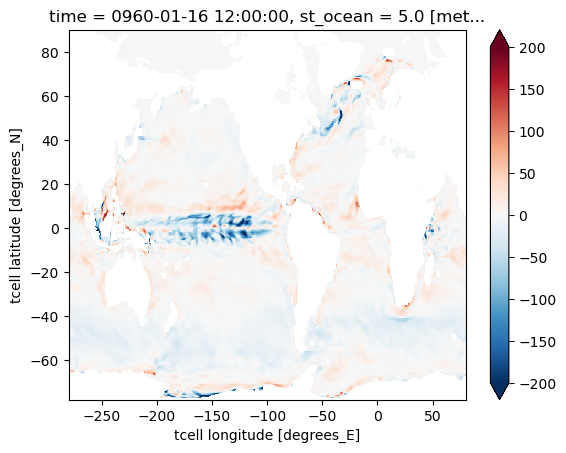

In [173]:
adv_offline_0[0].plot(vmin = -200)

In [152]:
#advection at surface layer

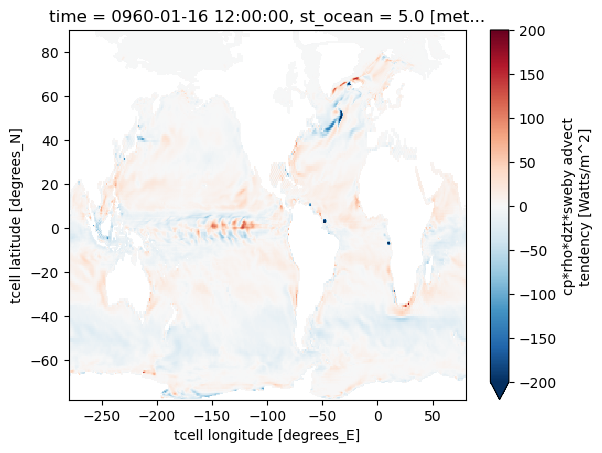

In [153]:
temp_advection[0,0].plot(vmin = -200)

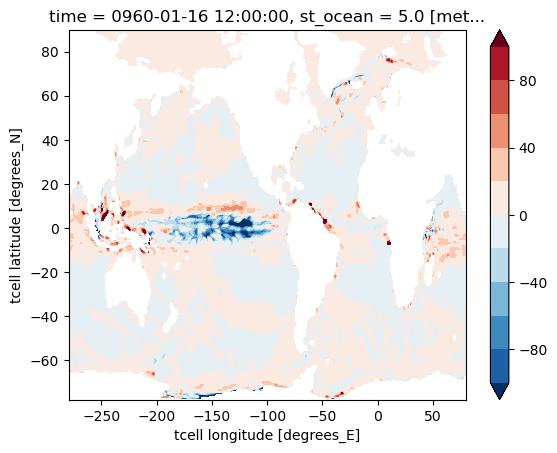

In [174]:
#difference
(adv_offline_0[0] - temp_advection[0,0]).plot.contourf(vmin = -100, levels = 11) 

In [75]:
#so in most places outside of the Pacific Ocean there are only small difference in the heat advection terms

In [76]:
adv_offline_50 = (uad1+vad1+wad1).sel(st_ocean = slice(0,50)).sum("st_ocean")

KeyError: "no index found for coordinate 'st_ocean'"

In [ ]:
adv_offline_50 =adv_offline_50.compute()

In [ ]:
adv_offline_50[0].plot(vmin = -400)

In [ ]:
temp_advection_50[0].plot(vmin = -400)

In [ ]:
(adv_offline_50- temp_advection_50)[0].plot.contourf(vmin = -400, levels = 11) 

In [301]:
ut= DS.temp_xflux_adv
vt= DS.temp_yflux_adv
wt= DS.temp_zflux_adv

In [176]:
#look at the fluxes going in and out of a cell at 8.83S, -249.5W

In [177]:
adv1 = temp_advection[0,0].sel(yt_ocean = -8.83, xt_ocean = -249.5, method = "nearest")

In [178]:
ut1 = ut[0,0,110,29]-ut[0,0,110,30]

In [179]:
vt1 = vt[0,0,109,30]-vt[0,0,110,30]

In [180]:
wt1 = wt[0,0,110,30]

In [140]:
area_t1 = DS.area_t.sel(yt_ocean = -8.83, xt_ocean = -249.5, method = "nearest")

In [142]:
(u1/area_t1 + v1/area_t1 +w1/area_t1).values

array(-24.82721, dtype=float32)

In [181]:
ut1.values/((dxt*dyt).sel(yt_ocean = -8.83, xt_ocean = -249.5, method = "nearest")).values

-73.98424

In [184]:
(vt[0,0,109,30]-vt[0,0,110,30]).values/((dxt*dyt).sel(yt_ocean = -8.83, xt_ocean = -249.5, method = "nearest")).values

669.84564

In [185]:
wt[0,0,110,30].values/((dxt*dyt).sel(yt_ocean = -8.83, xt_ocean = -249.5, method = "nearest")).values

-620.6886101226941

In [186]:
adv1.values

array(-24.82710648)

In [189]:
((ut1+vt1+wt1)/area_t1).values

array(-24.827204, dtype=float32)

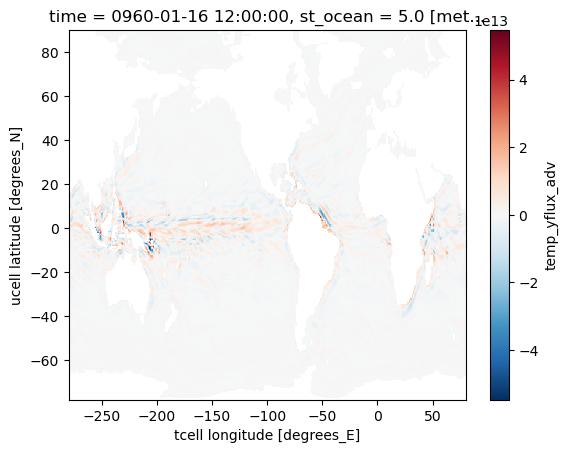

In [192]:
vt[0,0].differentiate("yu_ocean").plot() 

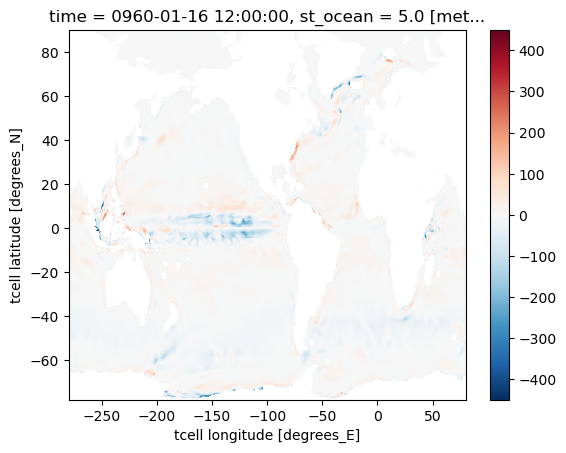

In [193]:
vad1[0].plot()

In [194]:
ds3 = xr.merge([ut, vt, wt])

In [197]:
ds3 = ds3.drop(['geolon_t', 'geolat_t'])

In [198]:
grid3 = xgcm.Grid(
    ds3,
    coords={"X": {"center": "xt_ocean", "right": "xu_ocean"},
            "Y": {"center": "yt_ocean", "right": "yu_ocean"},
            "Z": {"center": "st_ocean", "left": "sw_ocean"}}
)


In [199]:
grid3

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (periodic, boundary=None):
  * center   yt_ocean --> right
  * right    yu_ocean --> center
Z Axis (periodic, boundary=None):
  * center   st_ocean --> left
  * left     sw_ocean --> center

In [201]:
wt_ = grid3.interp(wt, axis = "Z", to="center")

In [265]:
ut_ = grid3.interp(ut.diff("xu_ocean"), axis = "X", to="center")

In [206]:
vt_ = grid3.interp(vt.diff("yu_ocean"), axis = "Y", to="center")

In [260]:
(ut.diff("xu_ocean"))[0,0].sel(yt_ocean = -8.83, xu_ocean = -249.5, method = "nearest").values

array(3.0130517e+11, dtype=float32)

In [267]:
(ut_)[0,0].sel(yt_ocean = -8.83, xt_ocean = -249.5, method = "nearest").values

array(-1.8913532e+11, dtype=float32)

In [257]:
(ut[0,0,110,29]-ut[0,0,110,30]).values

array(-3.0130517e+11, dtype=float32)

In [263]:
wt[0,0,110,30].values

array(-2.52779089e+12)

In [264]:
wt_[0,0,110,30].values

array(-3.4455867e+12, dtype=float32)

In [247]:
u_adv1 = ut_.diff("xt_ocean")/(dxt*dyt)
v_adv1 = vt_.diff("yt_ocean")/(dxt*dyt)
w_adv1 = wt_/(dxt*dyt)

In [250]:
adv2 = u_adv1+v_adv1+w_adv1

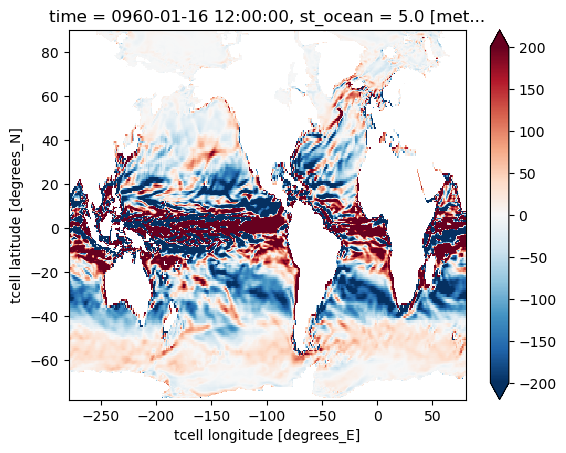

In [251]:
adv2[0,0].plot(vmin = -200)

In [304]:
ut2 = ut.diff("xu_ocean")
vt2 = vt.diff("yu_ocean")
wt2 = wt

In [305]:
ut2 = ut2.rename({"xu_ocean":"xt_ocean"})

In [306]:
ut2["xt_ocean"] = temp_advection.xt_ocean[1:]

In [307]:
vt2 = vt2.rename({"yu_ocean":"yt_ocean"})
vt2["yt_ocean"] = temp_advection.yt_ocean[1:]

In [308]:
wt2 = wt2.rename({"sw_ocean":"st_ocean"})
wt2["st_ocean"] = temp_advection.st_ocean

In [309]:
ut3 = ut2/(dxt*dyt)
vt3 = vt2/(dxt*dyt)
wt3 = wt2/(dxt*dyt)

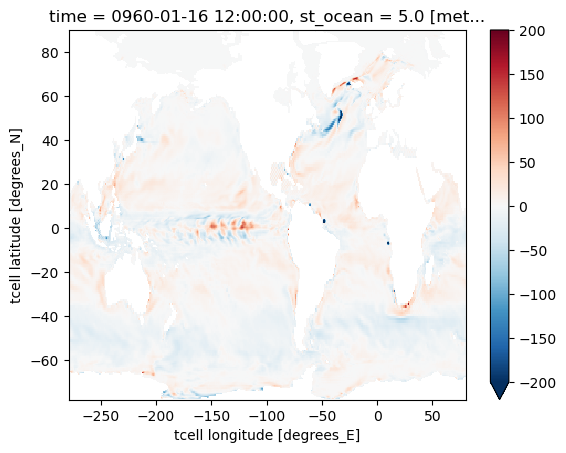

In [324]:
(-ut3-vt3+wt3)[0,0].plot(vmin = -200)

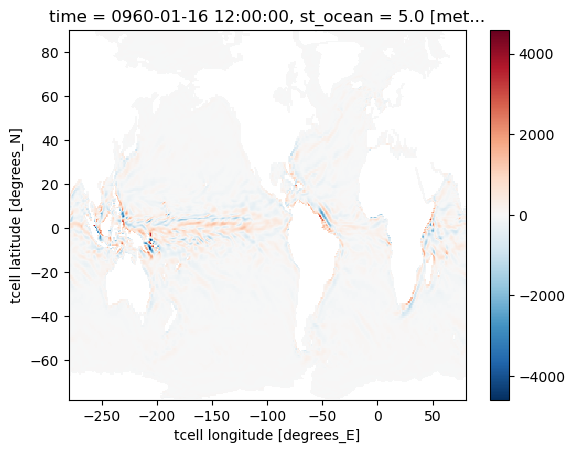

In [326]:
vt3[0,0].plot()

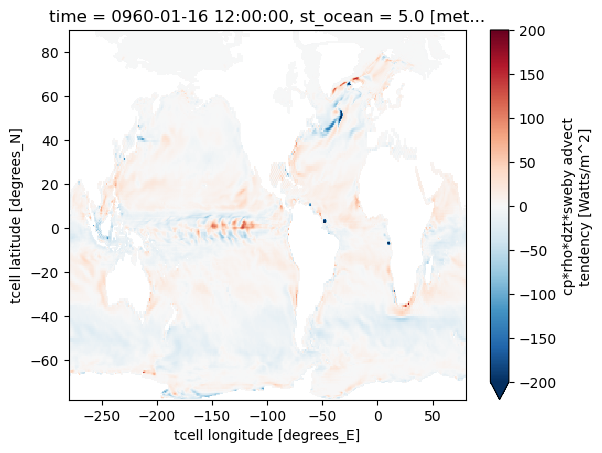

In [323]:
temp_advection[0,0].plot(vmin = -200)

In [316]:
ut3.sel(yt_ocean = -8.83, xt_ocean = -149.5, method = "nearest")[0,0].values

array(-420.3955, dtype=float32)

In [317]:
vt3.sel(yt_ocean = -8.83, xt_ocean = -149.5, method = "nearest")[0,0].values

array(69.94512, dtype=float32)

In [318]:
wt3.sel(yt_ocean = -8.83, xt_ocean = -149.5, method = "nearest")[0,0].values

array(-356.21924, dtype=float32)

In [321]:
temp_advection.sel(yt_ocean = -8.83, xt_ocean = -149.5, method = "nearest")[0,0].values

array(-5.76887417)

In [283]:
(ut2/(dxt*dyt)).sel(yt_ocean = -8.83, xt_ocean = -249.5, method = "nearest")[0,0].values

array(73.98424, dtype=float32)

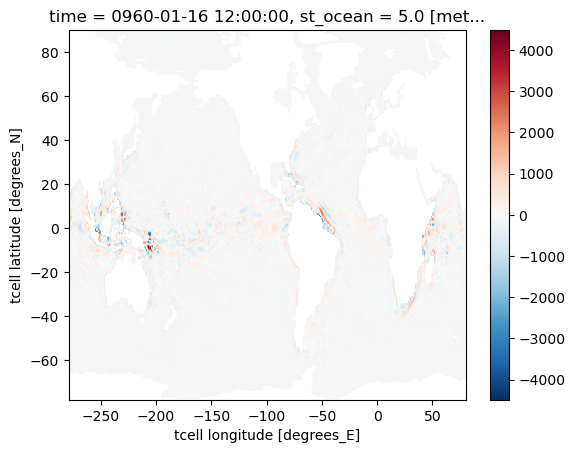

In [284]:
(ut2/(dxt*dyt))[0,0].plot()

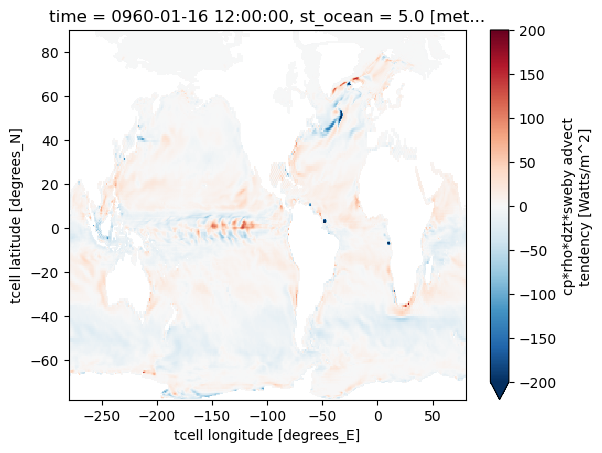

In [219]:
temp_advection[0,0].plot(vmin = -200)

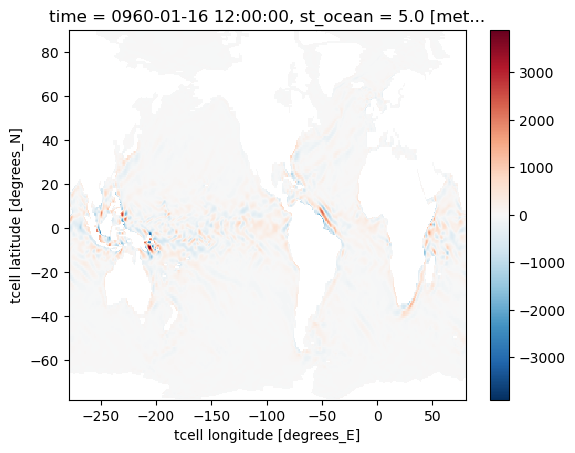

In [252]:
(ut_[0,0].diff("xt_ocean")/(area_t)).plot() 

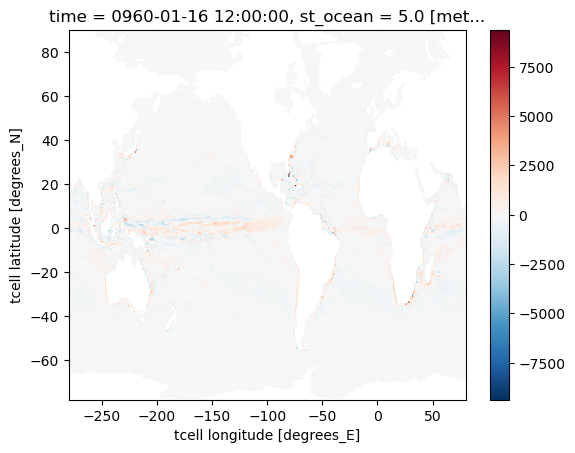

In [213]:
(wt_[0,0]/area_t1).plot() 

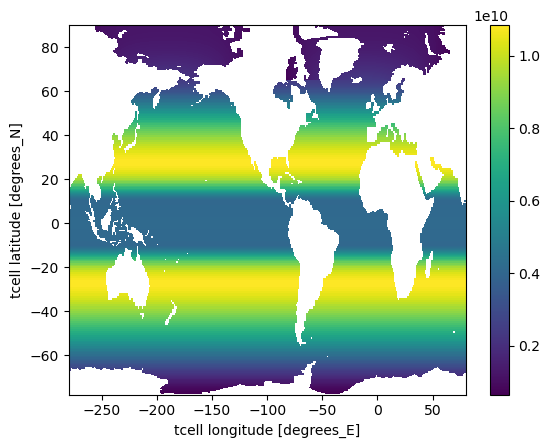

In [224]:
(dxt*dyt).plot()

In [227]:
area_t1

<xarray.DataArray 'area_t' ()>
dask.array<getitem, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    xt_ocean  float64 -249.5
    yt_ocean  float64 -8.833
    geolat_t  float32 dask.array<chunksize=(), meta=np.ndarray>
    geolon_t  float32 dask.array<chunksize=(), meta=np.ndarray>
Attributes:
    long_name:     tracer cell area
    units:         m^2
    valid_range:   [0.e+00 1.e+15]
    cell_methods:  time: point